# Step 3: Model Building — Baseline CNN

In this step, we define, train, evaluate, and save our first convolutional neural network (CNN) model, which serves as a **performance baseline** for later comparison and quantization.

---

## 3.1 Objective

This step supports **Hypothesis 1**:  
> A lightweight CNN trained on grayscale fruit images can achieve reasonable classification accuracy, even with minimal augmentation.

It also prepares the model for:

- Comparison with MobileNetV2 (**Hypothesis 2**)  
- Post-training quantization (**Hypothesis 3**)

---

## 3.2 CNN Architecture (Grayscale-Compatible)

Our baseline CNN is compact and designed for `100×100` **grayscale images** (1 input channel), as established in Step 2.

It consists of:

- 3 convolutional layers with ReLU activation and MaxPooling  
- 2 fully connected layers with ReLU and Dropout  
- A final softmax classifier layer for 8-class output

> ✅ **Note**: The first convolutional layer uses `in_channels=1` to match the grayscale input format.

---

## 3.3 Training Configuration

- **Loss Function**: `CrossEntropyLoss` (for multi-class classification)  
- **Optimizer**: `Adam` (learning rate = 0.001)  
- **Batch Size**: 32  
- **Epochs**: 10  
- **Evaluation**: Accuracy on a validation set (split from training data)

> **Note** : Apply class weights to handle imbalance

---

## 3.4 Training Procedure

- The model trains over multiple epochs on the training subset  
- For each batch:
  - Gradients are cleared  
  - Loss is computed  
  - Weights are updated  
- After each epoch, performance is evaluated on the **validation subset**  
- We record and visualize:
  - Training loss per epoch  
  - Validation accuracy per epoch

---

## 3.5 Model Saving

After training, we save the model weights to disk for later use:

```python
torch.save(model.state_dict(), "fruit_cnn_baseline_with_val.pth")

In [2]:
import os, sys, torch
sys.path.append(os.path.abspath("src"))

from data   import make_dataloaders
from models.cnn_small import create_fruit_cnn
from train  import TrainConfig, train_loop, test_accuracy
from viz    import plot_training_curves, plot_misclassified_images, misclassified_to_df
from PIL import Image
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# results collector
results_summary = {}


Device: cuda


In [3]:
##IMPORTANT TO CHECK!!!! We created grayscale loaders in Step 2 but dont know how to link them here. CHECK 

In [4]:
##IMPORTANT TO CHECK SEE THE CELL ABOVE !!!! 
TRAIN_DIR = 'Dataset/Training'
TEST_DIR  = 'Dataset/Test'
train_loader, val_loader, test_loader, class_weights, class_names, in_ch = make_dataloaders(
    TRAIN_DIR, TEST_DIR, batch_size=32, val_split=0.2, img_size=100,
    num_workers=0, seed=42, mode="grayscale", verbose=True
)
### SEE CURRENT CELL LATER TO CHECK FOR REFACTORING

[INFO] Seed: 42
[INFO] Mode: grayscale (in_channels=1, use_noise=False)
[INFO] Classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kaki 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] Sizes -> train: 3279, val: 819, test: 1365
[INFO] Class weights (mean≈1): [1.018 1.173 1.022 1.022 1.046 1.022 1.018 0.679]


In [5]:
exp = "Grayscale MaxPool"
model = create_fruit_cnn(pooling="max", in_channels=in_ch, num_classes=len(class_names))

cfg = TrainConfig(
    epochs=10, lr=1e-3, early_stop_patience=5,
    ckpt_path=f"experiments/runs/{exp.replace(' ','_')}_best.pt", seed=42
)

history, best_val = train_loop(model, train_loader, val_loader, class_weights, device, cfg)
test_acc = test_accuracy(model, cfg.ckpt_path, test_loader, device)
print(f"[{exp}] best_val={best_val:.4f} | test={test_acc:.4f}")

plot_buf = plot_training_curves(history["train_loss"], history["val_acc"])
results_summary[exp] = {
    "test_accuracy": test_acc,
    "train_losses": history["train_loss"],
    "val_accuracies": history["val_acc"],
    "plot": plot_buf,
    "ckpt": cfg.ckpt_path,
    "class_names": class_names,
    "in_channels": in_ch
}

# Optional extra save with friendly name
torch.save(model.state_dict(), "fruit_cnn_baseline_with_val.pth")


Epoch 1/10 | loss 0.8908 | val_acc 0.9658
Epoch 2/10 | loss 0.3137 | val_acc 0.9768
Epoch 3/10 | loss 0.2108 | val_acc 0.9976
Epoch 4/10 | loss 0.1347 | val_acc 0.9988
Epoch 5/10 | loss 0.1021 | val_acc 1.0000
Epoch 6/10 | loss 0.0842 | val_acc 0.9988
Epoch 7/10 | loss 0.0718 | val_acc 0.9988
Epoch 8/10 | loss 0.0580 | val_acc 1.0000
Epoch 9/10 | loss 0.0419 | val_acc 1.0000
Epoch 10/10 | loss 0.0544 | val_acc 1.0000
Early stopping.
[Grayscale MaxPool] best_val=1.0000 | test=0.8586


#### 3.6.1  Visualize Misclassified Test Images # todo detailed explanation and display a Few Misclassified Examples

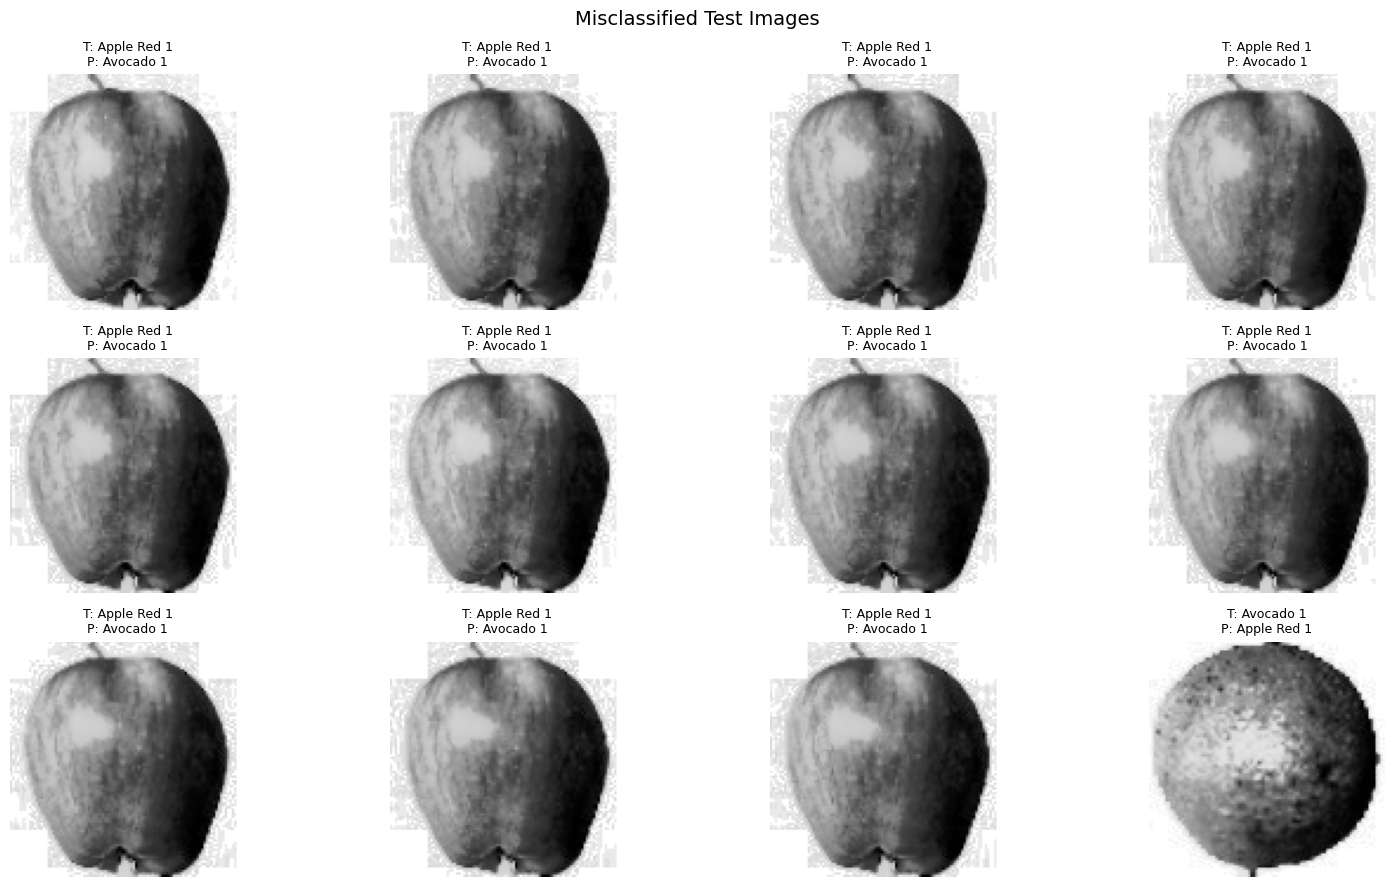

In [6]:
mis = plot_misclassified_images(
    model, 
    test_loader, 
    class_names, 
    device, 
    max_images=12, 
    save_path="reports/figures/misclassified_baseline.png" 
)


#### 3.6.7 Visualize DataFrame of mistakes

In [7]:
df_mis = misclassified_to_df(mis, class_names)
df_mis.head()

,true,pred
0,Apple Red 1,Avocado 1
1,Apple Red 1,Avocado 1
2,Apple Red 1,Avocado 1
3,Apple Red 1,Avocado 1
4,Apple Red 1,Avocado 1


#### 3.7 Improved CNN with Adaptive Pooling 

In [8]:
exp = "Grayscale AdaptiveAvgPool"
model = create_fruit_cnn(pooling="adaptiveavg", in_channels=in_ch, num_classes=len(class_names))
cfg = TrainConfig(epochs=10, lr=1e-3, early_stop_patience=5,
                  ckpt_path=f"experiments/runs/{exp.replace(' ','_')}_best.pt", seed=42)

history, best_val = train_loop(model, train_loader, val_loader, class_weights, device, cfg)
test_acc = test_accuracy(model, cfg.ckpt_path, test_loader, device)
print(f"[{exp}] best_val={best_val:.4f} | test={test_acc:.4f}")

plot_buf = plot_training_curves(history["train_loss"], history["val_acc"])
results_summary[exp] = {
    "test_accuracy": test_acc,
    "train_losses": history["train_loss"],
    "val_accuracies": history["val_acc"],
    "plot": plot_buf,
    "ckpt": cfg.ckpt_path,
    "class_names": class_names,
    "in_channels": in_ch
}


Epoch 1/10 | loss 0.8688 | val_acc 0.9328
Epoch 2/10 | loss 0.3140 | val_acc 0.9829
Epoch 3/10 | loss 0.2318 | val_acc 0.9927
Epoch 4/10 | loss 0.1528 | val_acc 0.9976
Epoch 5/10 | loss 0.1296 | val_acc 0.9963
Epoch 6/10 | loss 0.0914 | val_acc 0.9976
Epoch 7/10 | loss 0.0801 | val_acc 1.0000
Epoch 8/10 | loss 0.0594 | val_acc 0.9988
Epoch 9/10 | loss 0.0603 | val_acc 0.9988
Epoch 10/10 | loss 0.0370 | val_acc 1.0000
[Grayscale AdaptiveAvgPool] best_val=1.0000 | test=0.8747


* Despite expectations, max-pooling outperforms adaptive average pooling on both validation and test sets. This suggests that fine-grained textural activations are more helpful than global shape layout for this task, possibly due to lighting, resolution, or dataset scale.

#### 3.8 CNN with RGB Input

In this step, we extend our investigation by training the lightweight CNN model on **RGB images** instead of grayscale. This allows us to evaluate the **Grayscale Hypothesis**:

> *Grayscale input can be as effective as RGB for fruit classification, while reducing memory and compute requirements.*

By using the same model architecture with RGB inputs (3 channels), we can quantify any performance difference.


#### 3.8.1–3.8.2 Build RGB loaders (with/without noise)

In [9]:
# with noise
rgb_train, rgb_val, rgb_test, rgb_w, rgb_names, rgb_in_ch = make_dataloaders(
    TRAIN_DIR, TEST_DIR, batch_size=32, val_split=0.2, img_size=100,
    num_workers=0, seed=42, mode="rgb", use_noise=True, verbose=True
)

# without noise
rgb_train_clean, rgb_val_clean, rgb_test_clean, rgb_w_clean, rgb_names_clean, _ = make_dataloaders(
    TRAIN_DIR, TEST_DIR, batch_size=32, val_split=0.2, img_size=100,
    num_workers=0, seed=42, mode="rgb", use_noise=False, verbose=True
)


[INFO] Seed: 42
[INFO] Mode: rgb (in_channels=3, use_noise=True)
[INFO] Classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kaki 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] Sizes -> train: 3279, val: 819, test: 1365
[INFO] Class weights (mean≈1): [1.018 1.173 1.022 1.022 1.046 1.022 1.018 0.679]
[INFO] Seed: 42
[INFO] Mode: rgb (in_channels=3, use_noise=False)
[INFO] Classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kaki 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] Sizes -> train: 3279, val: 819, test: 1365
[INFO] Class weights (mean≈1): [1.018 1.173 1.022 1.022 1.046 1.022 1.018 0.679]


#### 3.8.3–3.8.4 Train & evaluate RGB variants

*RGB with noise*

In [10]:
exp = "RGB CNN With Noise"
model = create_fruit_cnn(pooling="max", in_channels=rgb_in_ch, num_classes=len(rgb_names))
cfg = TrainConfig(epochs=10, lr=1e-3, early_stop_patience=5,
                  ckpt_path=f"experiments/runs/{exp.replace(' ','_')}_best.pt", seed=42)

history, best_val = train_loop(model, rgb_train, rgb_val, rgb_w, device, cfg)
test_acc = test_accuracy(model, cfg.ckpt_path, rgb_test, device)
print(f"[{exp}] best_val={best_val:.4f} | test={test_acc:.4f}")

plot_buf = plot_training_curves(history["train_loss"], history["val_acc"])
results_summary[exp] = {
    "test_accuracy": test_acc,
    "train_losses": history["train_loss"],
    "val_accuracies": history["val_acc"],
    "plot": plot_buf,
    "ckpt": cfg.ckpt_path,
    "class_names": rgb_names,
    "in_channels": rgb_in_ch
}


Epoch 1/10 | loss 0.4758 | val_acc 0.9988
Epoch 2/10 | loss 0.1204 | val_acc 1.0000
Epoch 3/10 | loss 0.0386 | val_acc 0.9988
Epoch 4/10 | loss 0.0308 | val_acc 0.9988
Epoch 5/10 | loss 0.0099 | val_acc 1.0000
Epoch 6/10 | loss 0.0177 | val_acc 1.0000
Epoch 7/10 | loss 0.0074 | val_acc 1.0000
Early stopping.
[RGB CNN With Noise] best_val=1.0000 | test=0.8725


*RGB without noise*

In [11]:
exp = "RGB CNN Without Noise"
model = create_fruit_cnn(pooling="max", in_channels=rgb_in_ch, num_classes=len(rgb_names_clean))
cfg = TrainConfig(epochs=10, lr=1e-3, early_stop_patience=5,
                  ckpt_path=f"experiments/runs/{exp.replace(' ','_')}_best.pt", seed=42)

history, best_val = train_loop(model, rgb_train_clean, rgb_val_clean, rgb_w_clean, device, cfg)
test_acc = test_accuracy(model, cfg.ckpt_path, rgb_test_clean, device)
print(f"[{exp}] best_val={best_val:.4f} | test={test_acc:.4f}")

plot_buf = plot_training_curves(history["train_loss"], history["val_acc"])
results_summary[exp] = {
    "test_accuracy": test_acc,
    "train_losses": history["train_loss"],
    "val_accuracies": history["val_acc"],
    "plot": plot_buf,
    "ckpt": cfg.ckpt_path,
    "class_names": rgb_names_clean,
    "in_channels": rgb_in_ch
}


Epoch 1/10 | loss 0.4483 | val_acc 0.9927
Epoch 2/10 | loss 0.0623 | val_acc 0.9890
Epoch 3/10 | loss 0.0311 | val_acc 0.9988
Epoch 4/10 | loss 0.0171 | val_acc 0.9988
Epoch 5/10 | loss 0.0145 | val_acc 1.0000
Epoch 6/10 | loss 0.0085 | val_acc 0.9988
Epoch 7/10 | loss 0.0011 | val_acc 0.9988
Epoch 8/10 | loss 0.0007 | val_acc 0.9988
Epoch 9/10 | loss 0.0106 | val_acc 0.9988
Epoch 10/10 | loss 0.0315 | val_acc 1.0000
Early stopping.
[RGB CNN Without Noise] best_val=1.0000 | test=0.8857


#### 3.8.5 Visual summary / comparison

=== CNN Experiment Comparison ===
Grayscale MaxPool: Test Accuracy = 0.8586


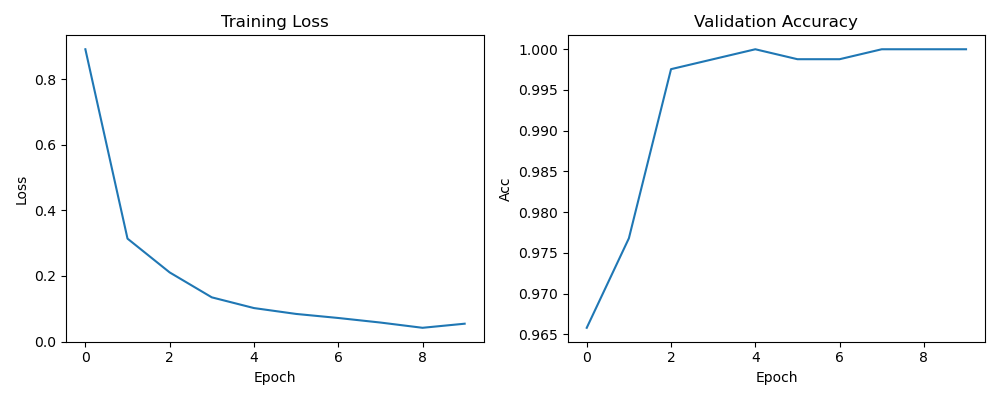

Grayscale AdaptiveAvgPool: Test Accuracy = 0.8747


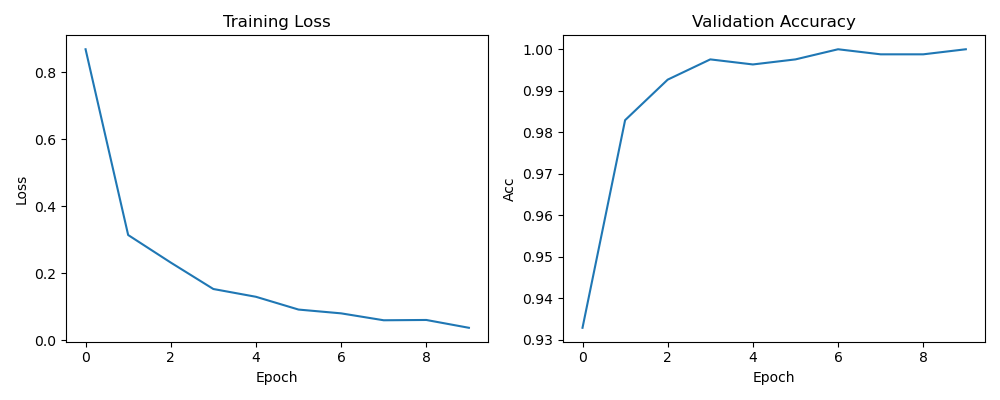

RGB CNN With Noise: Test Accuracy = 0.8725


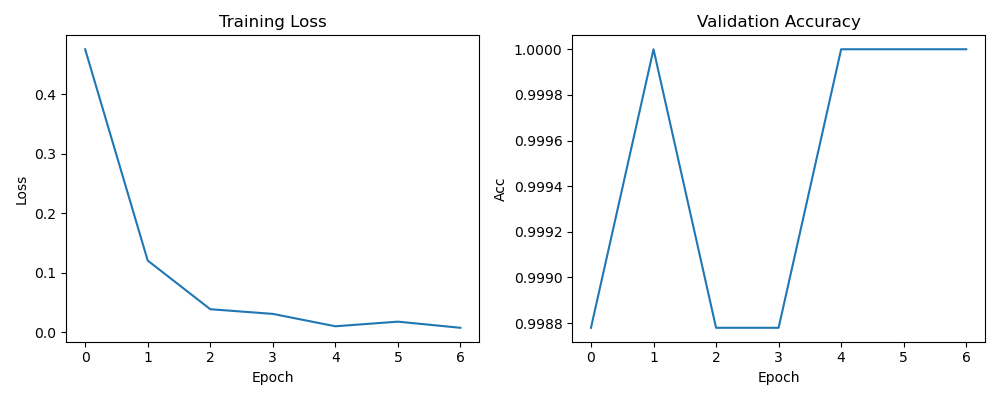

RGB CNN Without Noise: Test Accuracy = 0.8857


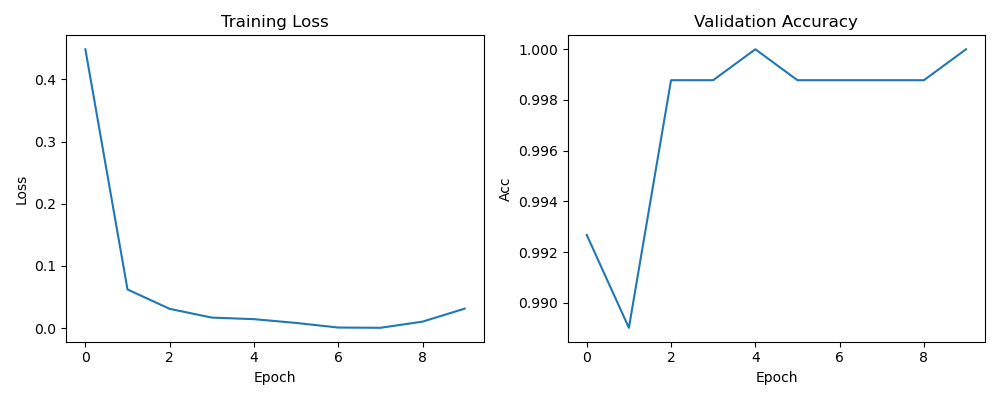

In [12]:
print("=== CNN Experiment Comparison ===")
for name, result in results_summary.items():
    print(f"{name}: Test Accuracy = {result['test_accuracy']:.4f}")
    img = Image.open(result["plot"])
    display(img)